In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Initialize the lattice
def initialize_lattice(size):
    lattice = np.zeros((size, size), dtype = int) # Create an empty 2D lattice of dimensions size * size
    return lattice

In [3]:
# Compute neighbor indices with periodic boundary conditions
def compute_neighbor_indices(size):
    neighbor_indices = {} # Create an empty dictionary 'neighbor indices'
    
    for x in range(size): 
        for y in range(size): 
            # Boundary conditions:
            neighbors = [
                ((x - 1) % size, y),     
                ((x + 1) % size, y),     
                (x, (y - 1) % size),     
                (x, (y + 1) % size)      
            ]
            
            neighbor_indices[(x, y)] = neighbors # Add neighbors to the dictionary
    return neighbor_indices

In [4]:
# Calculate interaction energy
def calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB):
    x, y = site # Set x, y to coordinates of 'site'
    interaction_energy = 0 # Set 'interaction energy' to 0
    # Go throgh every neighbor in all sites
    for neighbor in neighbor_indices[(x, y)]:
        neighbor_particle = lattice[neighbor]
        if neighbor_particle != 0: # If neighbor particle is not empty (0)
            if particle == 1: # Particle A
                if neighbor_particle == 1: # Neighbor particle is A
                    interaction_energy += epsilon_AA # Interaction between particle A and particle A
                else: # Neighbor particle is B
                    interaction_energy += epsilon_AB # Interaction between particle A and particle B
            else: # Particle B
                if neighbor_particle == 2: # Neighbor particle is B
                    interaction_energy += epsilon_BB # Interaction between particle B and particle B
                else: # Neighbor particle is A 
                    interaction_energy += epsilon_AB # Interaction between particle A and particle B
    return interaction_energy

In [5]:
# Attempt to add or remove a particle
def attempt_move(lattice, N_A, N_B, N_empty, neighbor_indices, params):
    size = lattice.shape[0] # Set size to dimension of lattice
    N_sites = size * size # Set N_sites to size * size
    beta = 1 / params['T'] # Set beta to 1/params['T']
    
    # Extract parameters
    epsilon_A = params['epsilon_A']
    epsilon_B = params['epsilon_B']
    epsilon_AA = params['epsilon_AA']
    epsilon_BB = params['epsilon_BB']
    epsilon_AB = params['epsilon_AB']
    mu_A = params['mu_A']
    mu_B = params['mu_B']
    
    # Decide wether to add ot remove a particle
    if np.random.rand() < 0.5: # If adding a particle
        if N_empty == 0:
            return N_A, N_B, N_empty # No empty sites available
        
        # Select a random site in empty sites
        empty_sites = list(zip(*np.where(lattice == 0)))
        site = empty_sites[np.random.randint(len(empty_sites))]

        # Decide which particle (A or B) to add with equal probability
        if np.random.rand() < 0.5: # Adding particle A
            particle = 1
            mu = mu_A
            epsilon = epsilon_A
            N_s = N_A
        else: # Adding particle B
            particle = 2
            mu = mu_B
            epsilon = epsilon_B
            N_s = N_B
        
        # Calculate energy change 'delta E'
        delta_E = epsilon + calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB)
        # Calculate acceptance probability
        acc_prob = min(1, (N_empty / (N_s + 1)) * np.exp(-beta * (delta_E - mu)))
        
        r = np.random.rand() # Generate a random number 'r' between 0 to 1
        if r < acc_prob: # Adding particle A
            lattice[site] = particle
            if particle == 1:
                N_A += 1
            else: # Adding particle B
                N_B += 1
            N_empty -=1
    else: # Removing a particle
        if N_sites - N_empty == 0:
            return N_A, N_B, N_empty # No particles to remove

        # Select a random 'site' from occupied sites in 'lattice'
        occupied_sites = list(zip(*np.where(lattice != 0)))
        site = occupied_sites[np.random.randint(len(occupied_sites))]
        particle = lattice[site]
        
        if particle == 1: # Removing particle A
            mu = mu_A
            epsilon = epsilon_A
            N_s = N_A
        else: # Removing particle B
            mu = mu_B
            epsilon = epsilon_B
            N_s = N_B
        
        # Calculate energy change 'delta E'
        delta_E = -epsilon - calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB)
        # Calculate acceptance probability
        acc_prob = min(1, (N_s / (N_empty + 1)) * np.exp(-beta * (delta_E + mu)))
        
        r = np.random.rand() # Generate a random number 'r' between 0 to 1
        if r < acc_prob: # Removing particle A
            lattice[site] = 0
            if particle == 1:
                N_A -= 1
            else: # Removing particle B
                N_B -= 1
            N_empty += 1
    
    return N_A, N_B, N_empty
           

In [6]:
# Run the GCMC simulation
def run_simulation(size, n_steps, params):
    #  Initialize lattice, compute neighbor indices
    lattice = initialize_lattice(size)
    neighbor_indices = compute_neighbor_indices(size)
    N_sites = size * size

    # Initialize counts
    N_A = 0
    N_B = 0
    N_empty = N_sites

    # Create arrays 'coverage_A' and 'coverage_B' of length 'n_steps'
    coverage_A = np.zeros(n_steps)
    coverage_B = np.zeros(n_steps)

    # Run the simulation
    for step in range(n_steps):
        N_A, N_B, N_empty = attempt_move(lattice, N_A, N_B, N_empty, neighbor_indices, params) # Update N_A, N_B and N_empty
        # Compute coverage of A and B at each step
        coverage_A[step] = N_A / N_sites
        coverage_B[step] = N_B / N_sites
    
    return lattice, coverage_A, coverage_B

In [7]:
# Plot lattice configuration
def plot_lattice(lattice, ax, title):
    size = lattice.shape[0] # Set 'size' to dimension of 'lattice'
    # Go through all each lattice and plot the particle
    for x in range(size):
        for y in range(size):
            if lattice[x, y] == 1: # Particle A , plot red circle
                circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')
                ax.add_patch(circle)
            elif lattice[x, y] == 2: # Particle B, plot blue circle
                circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
                ax.add_patch(circle)
    # Set axis limits and labels
    ax.set_xlim(0, size) # x-axis from 0 to 'size'
    ax.set_ylim(0, size) # y-axis from 0 to 'size'
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(color='grey', linestyle='--', linewidth = 0.5)
    ax.set_title(title) # Set axis title
    
    return ax

C:\Users\16671\AppData\Local\Temp\ipykernel_16972\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_16972\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


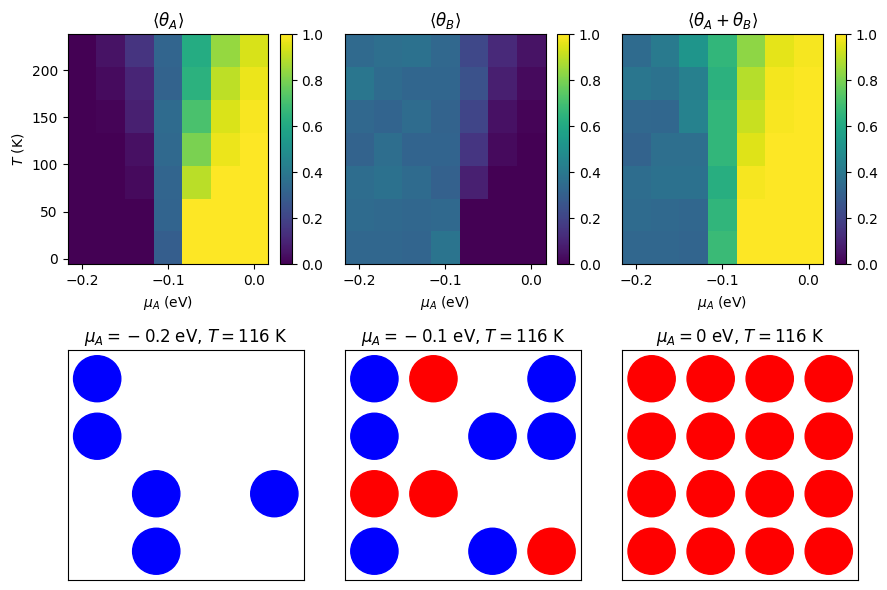

In [8]:
# Using the provided example code snippet in Lecture 19 to test the implementation
# Parameters
size = 4
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1,
            'epsilon_B': -0.1,
            'epsilon_AA': 0,
            'epsilon_BB': 0,
            'epsilon_AB': 0,
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1) # Convert /k to K
axs[0, 0].set_title(r'$\langle \theta_A \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_B \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_A + \theta_B \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_A = -0.2$ eV, $T = 116$ K') # 0.01/k = 116 K

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_A = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_A = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.show()


In [9]:
# Ideal MixtUre of Nitrogen and Hydrogen 

C:\Users\16671\AppData\Local\Temp\ipykernel_16972\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_16972\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


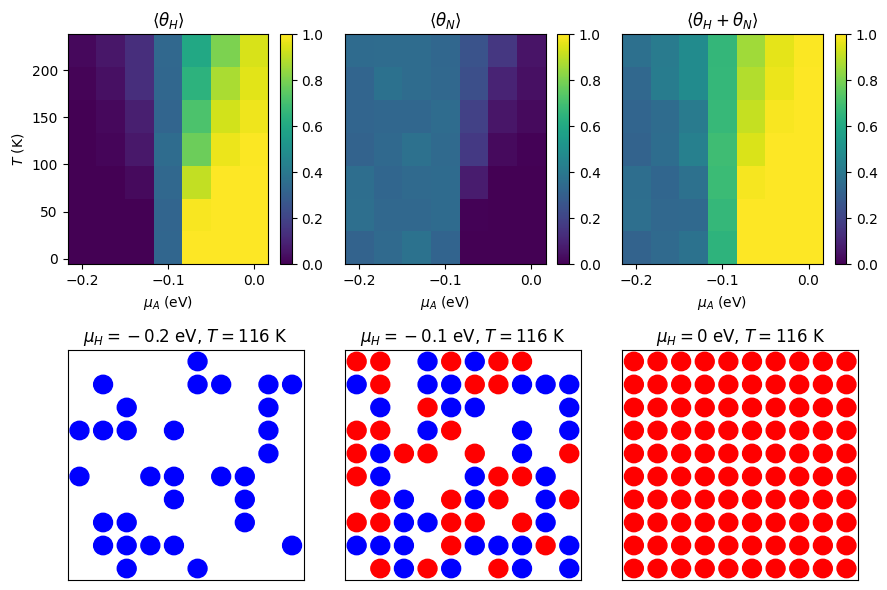

In [10]:
# Ideal Mixture of Nitrogen and Hydrogen #1
# A: Hydrogen; B: Nitrogen
# Parameters
size = 10 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 10 * 10
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0,   # epsilon_HH = 0 eV
            'epsilon_BB': 0,   # epsilon_NN = 0 eV
            'epsilon_AB': 0,   # epsilon_NH = 0 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Ideal Mixture of Nitrogen and Hydrogen (Lattice Size = 10).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


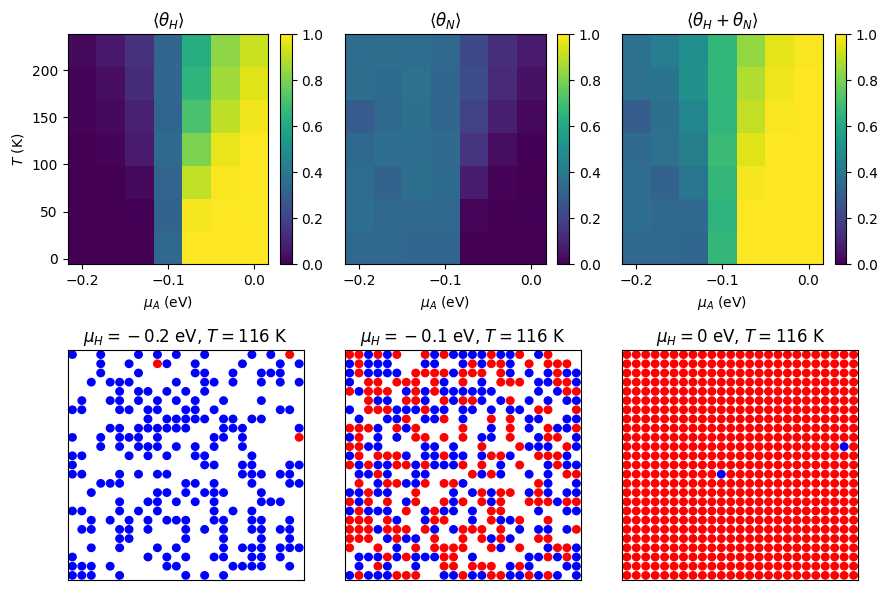

In [12]:
# Ideal Mixture of Nitrogen and Hydrogen #2
# A: Hydrogen; B: Nitrogen
# Parameters
size = 25 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 25 * 25
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0,   # epsilon_HH = 0 eV
            'epsilon_BB': 0,   # epsilon_NN = 0 eV
            'epsilon_AB': 0,   # epsilon_NH = 0 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Ideal Mixture of Nitrogen and Hydrogen (Lattice Size = 25).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


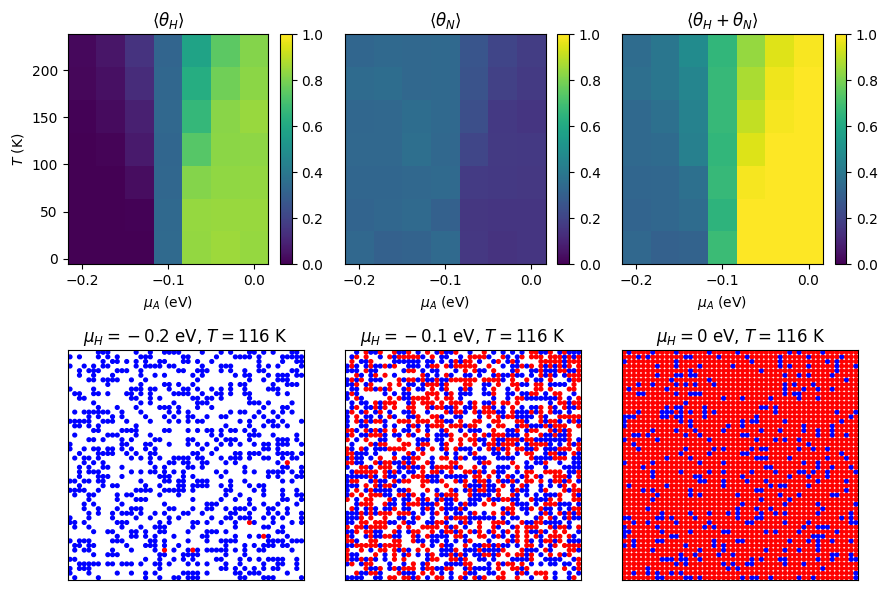

In [13]:
# Ideal Mixture of Nitrogen and Hydrogen #3
# A: Hydrogen; B: Nitrogen
# Parameters
size = 50 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 50 * 50
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0,   # epsilon_HH = 0 eV
            'epsilon_BB': 0,   # epsilon_NN = 0 eV
            'epsilon_AB': 0,   # epsilon_NH = 0 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Ideal Mixture of Nitrogen and Hydrogen (Lattice Size = 50).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


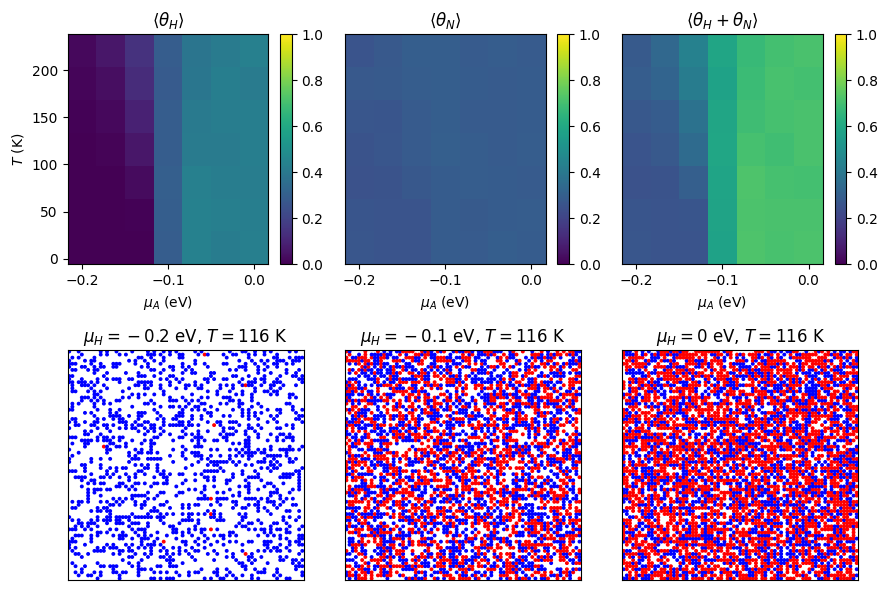

In [14]:
# Ideal Mixture of Nitrogen and Hydrogen #4
# A: Hydrogen; B: Nitrogen
# Parameters
size = 75 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 75 * 75
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0,   # epsilon_HH = 0 eV
            'epsilon_BB': 0,   # epsilon_NN = 0 eV
            'epsilon_AB': 0,   # epsilon_NH = 0 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Ideal Mixture of Nitrogen and Hydrogen (Lattice Size = 75).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


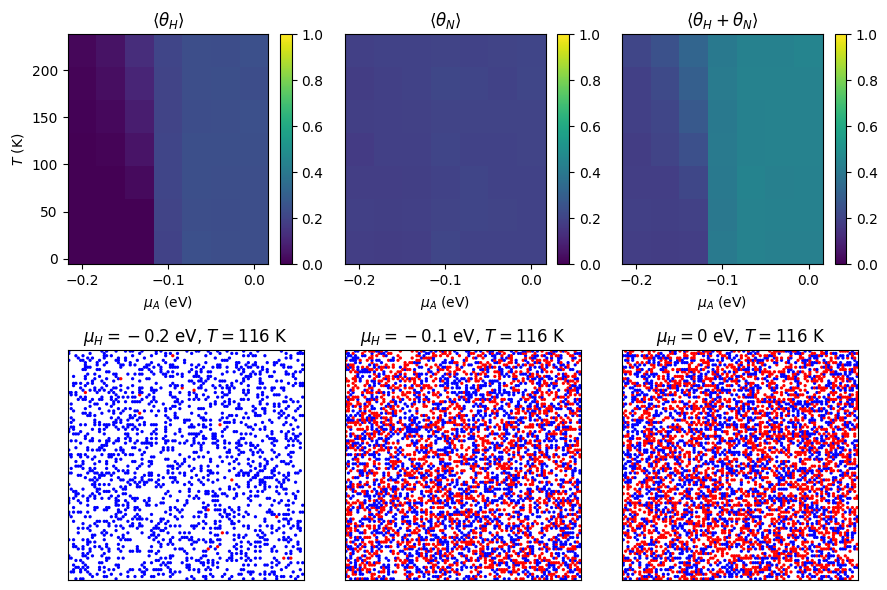

In [15]:
# Ideal Mixture of Nitrogen and Hydrogen #5
# A: Hydrogen; B: Nitrogen
# Parameters
size = 100 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 100 * 100
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0,   # epsilon_HH = 0 eV
            'epsilon_BB': 0,   # epsilon_NN = 0 eV
            'epsilon_AB': 0,   # epsilon_NH = 0 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Ideal Mixture of Nitrogen and Hydrogen (Lattice Size = 100).png')
plt.show()

In [16]:
# Repulsive Interactions between Nitrogen and Hydrogen

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


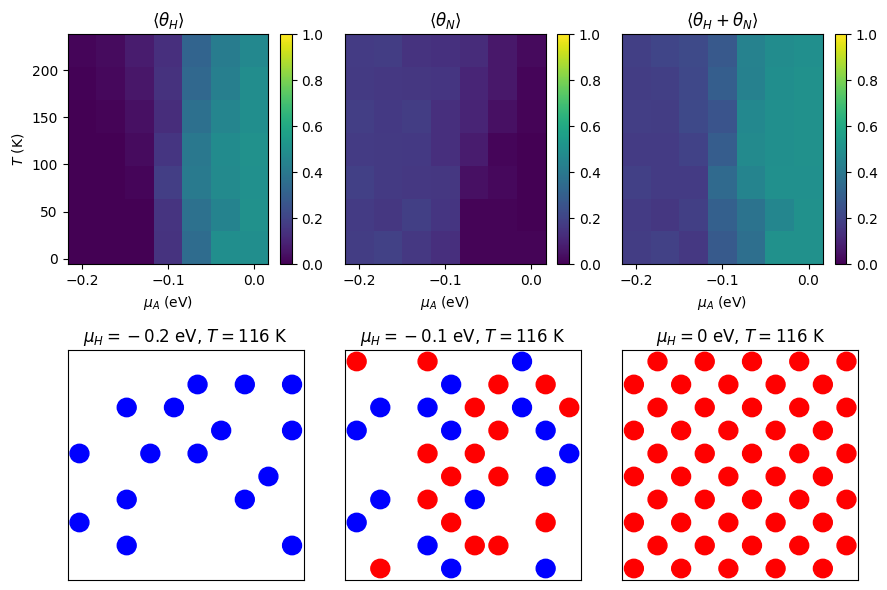

In [17]:
# Repulsive Interactions between Nitrogen and Hydrogen #1
# A: Hydrogen; B: Nitrogen
# Parameters
size = 10 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 10 * 10
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0.05,   # epsilon_HH = 0.05 eV
            'epsilon_BB': 0.05,   # epsilon_NN = 0.05 eV
            'epsilon_AB': 0.05,   # epsilon_NH = 0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Repulsive Interactions between Nitrogen and Hydrogen (Lattice Size = 10).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


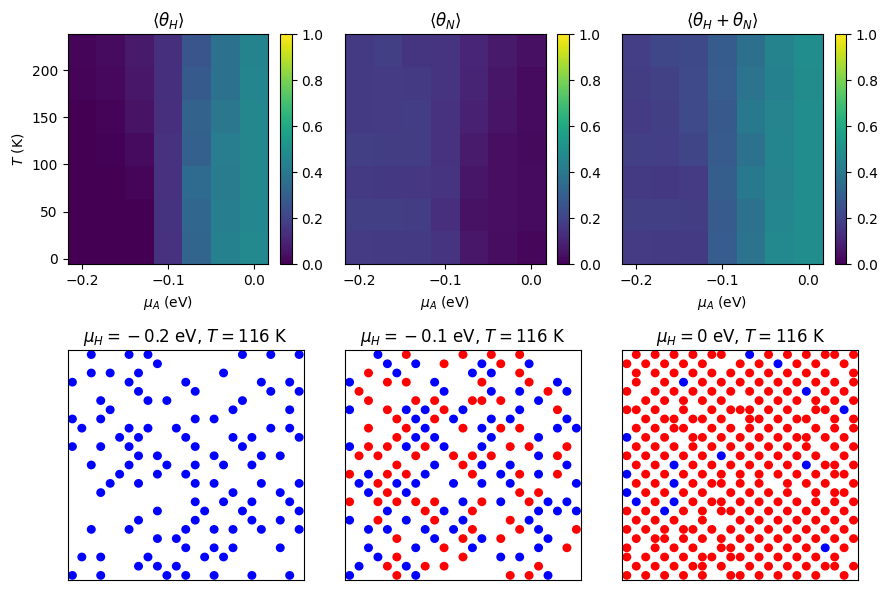

In [18]:
# Repulsive Interactions between Nitrogen and Hydrogen #2
# A: Hydrogen; B: Nitrogen
# Parameters
size = 25 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 25 * 25
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0.05,   # epsilon_HH = 0.05 eV
            'epsilon_BB': 0.05,   # epsilon_NN = 0.05 eV
            'epsilon_AB': 0.05,   # epsilon_NH = 0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Repulsive Interactions between Nitrogen and Hydrogen (Lattice Size = 25).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


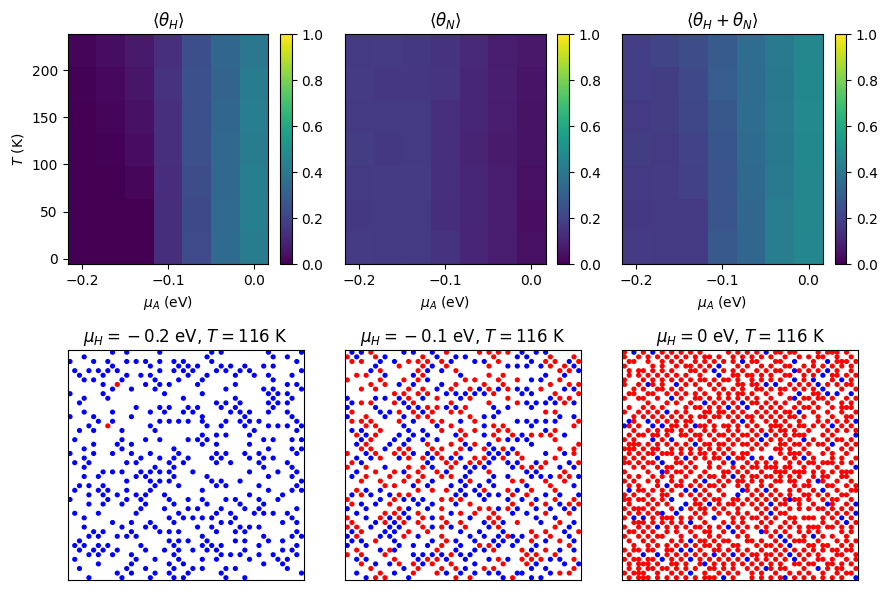

In [19]:
# Repulsive Interactions between Nitrogen and Hydrogen #3
# A: Hydrogen; B: Nitrogen
# Parameters
size = 50 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 50 * 50
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0.05,   # epsilon_HH = 0.05 eV
            'epsilon_BB': 0.05,   # epsilon_NN = 0.05 eV
            'epsilon_AB': 0.05,   # epsilon_NH = 0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Repulsive Interactions between Nitrogen and Hydrogen (Lattice Size = 50).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


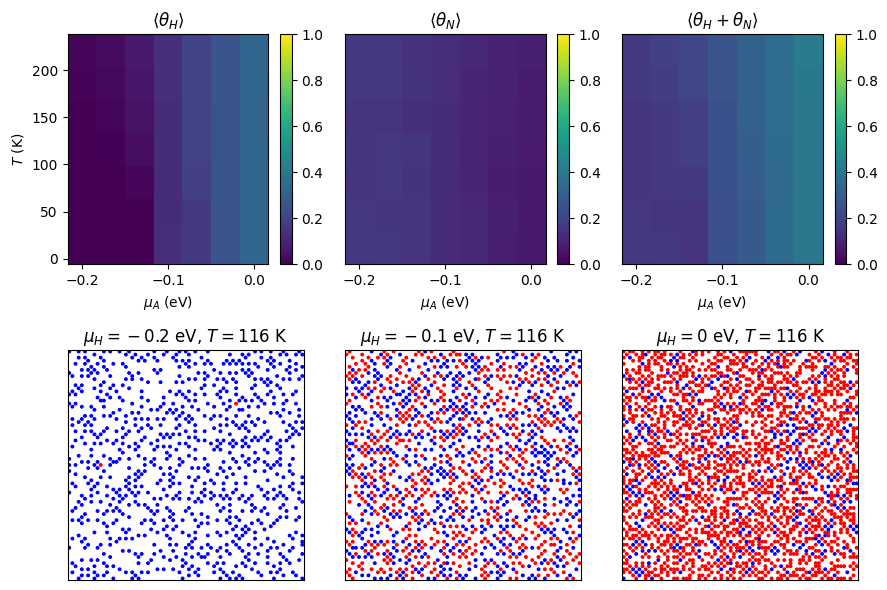

In [20]:
# Repulsive Interactions between Nitrogen and Hydrogen #4
# A: Hydrogen; B: Nitrogen
# Parameters
size = 75 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 75 * 75
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0.05,   # epsilon_HH = 0.05 eV
            'epsilon_BB': 0.05,   # epsilon_NN = 0.05 eV
            'epsilon_AB': 0.05,   # epsilon_NH = 0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Repulsive Interactions between Nitrogen and Hydrogen (Lattice Size = 75).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


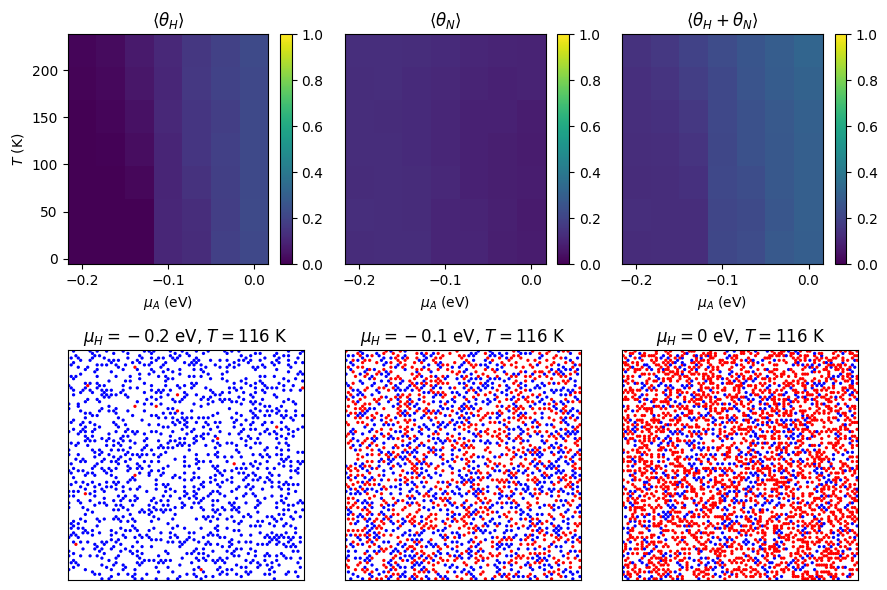

In [21]:
# Repulsive Interactions between Nitrogen and Hydrogen #5
# A: Hydrogen; B: Nitrogen
# Parameters
size = 100 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 100 * 100
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0.05,   # epsilon_HH = 0.05 eV
            'epsilon_BB': 0.05,   # epsilon_NN = 0.05 eV
            'epsilon_AB': 0.05,   # epsilon_NH = 0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Repulsive Interactions between Nitrogen and Hydrogen (Lattice Size = 100).png')
plt.show()

In [22]:
# Attractive Interactions between Nitrogen and Hydrogen

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


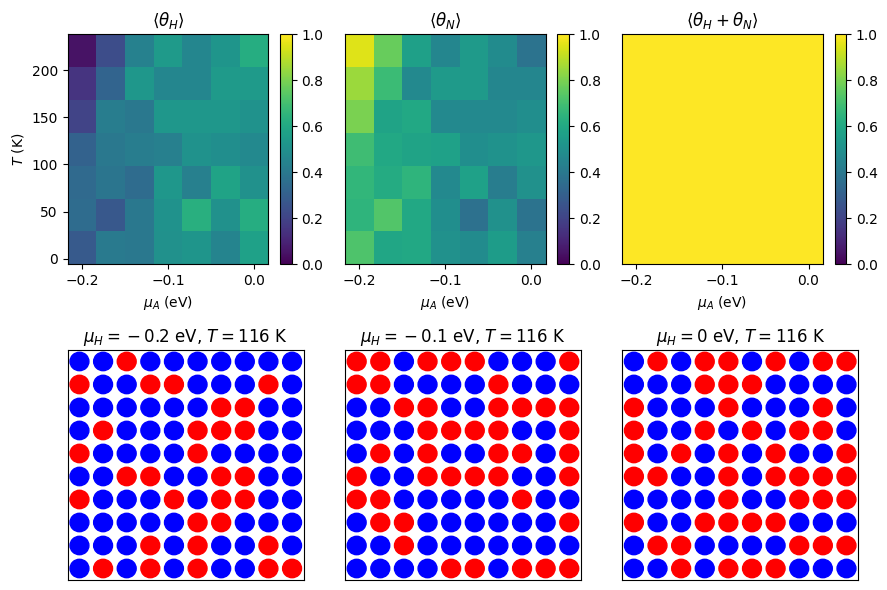

In [23]:
# Attractive Interactions between Nitrogen and Hydrogen #1
# A: Hydrogen; B: Nitrogen
# Parameters
size = 10 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 10 * 10
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': -0.05,   # epsilon_HH = -0.05 eV
            'epsilon_BB': -0.05,   # epsilon_NN = -0.05 eV
            'epsilon_AB': -0.05,   # epsilon_NH = -0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Attractive Interactions between Nitrogen and Hydrogen (Lattice Size = 10).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


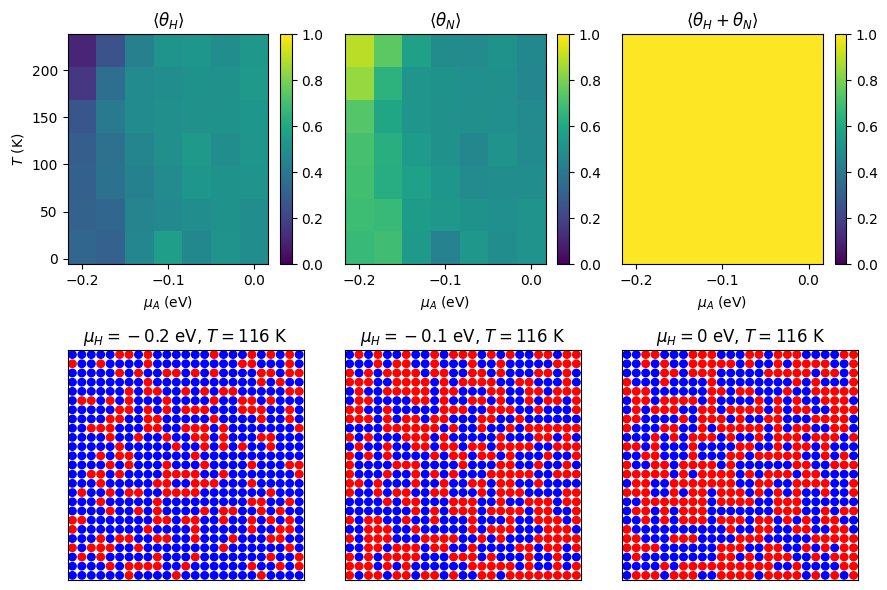

In [24]:
# Attractive Interactions between Nitrogen and Hydrogen #2
# A: Hydrogen; B: Nitrogen
# Parameters
size = 25 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 25 * 25
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': -0.05,   # epsilon_HH = -0.05 eV
            'epsilon_BB': -0.05,   # epsilon_NN = -0.05 eV
            'epsilon_AB': -0.05,   # epsilon_NH = -0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Attractive Interactions between Nitrogen and Hydrogen (Lattice Size = 25).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


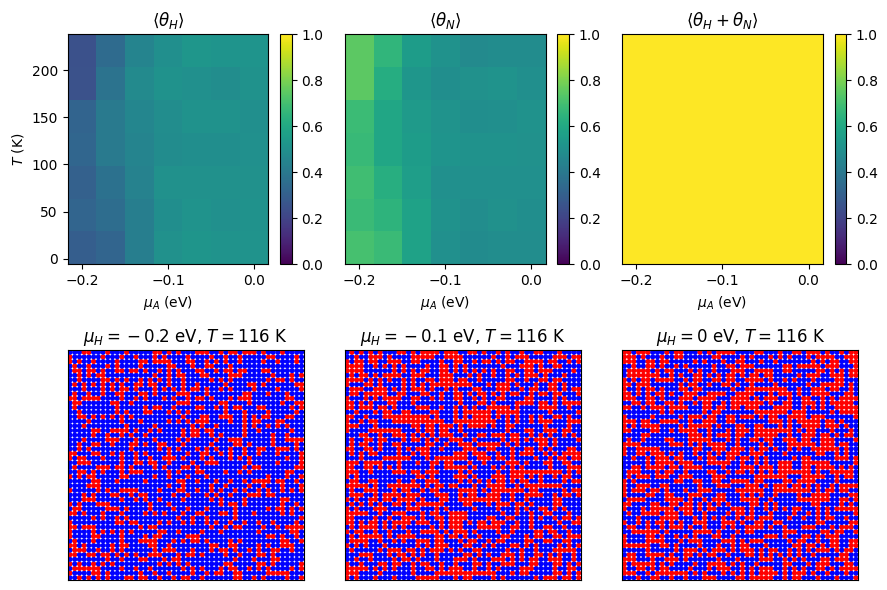

In [25]:
# Attractive Interactions between Nitrogen and Hydrogen #3
# A: Hydrogen; B: Nitrogen
# Parameters
size = 50 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 50 * 50
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': -0.05,   # epsilon_HH = -0.05 eV
            'epsilon_BB': -0.05,   # epsilon_NN = -0.05 eV
            'epsilon_AB': -0.05,   # epsilon_NH = -0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Attractive Interactions between Nitrogen and Hydrogen (Lattice Size = 50).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


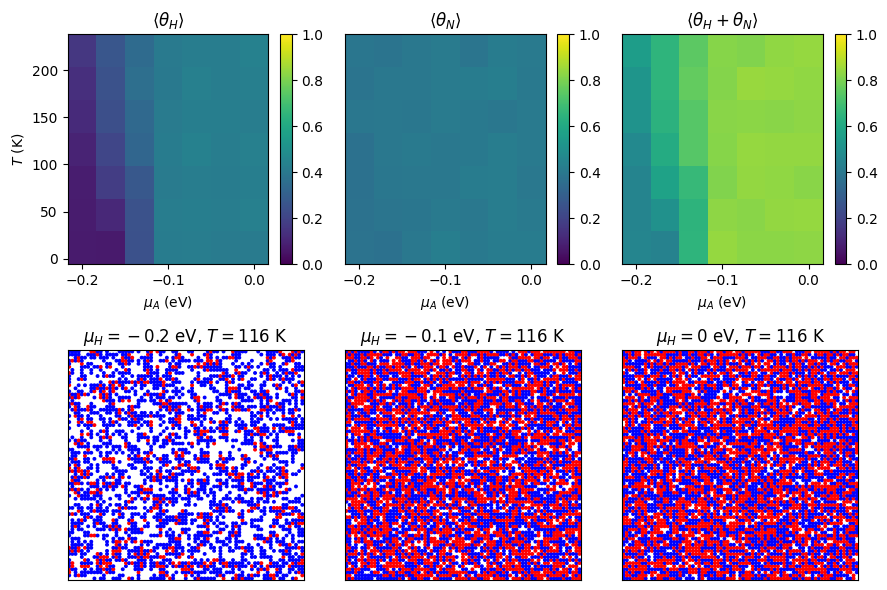

In [26]:
# Attractive Interactions between Nitrogen and Hydrogen #4
# A: Hydrogen; B: Nitrogen
# Parameters
size = 75 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 75 * 75
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': -0.05,   # epsilon_HH = -0.05 eV
            'epsilon_BB': -0.05,   # epsilon_NN = -0.05 eV
            'epsilon_AB': -0.05,   # epsilon_NH = -0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Attractive Interactions between Nitrogen and Hydrogen (Lattice Size = 75).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


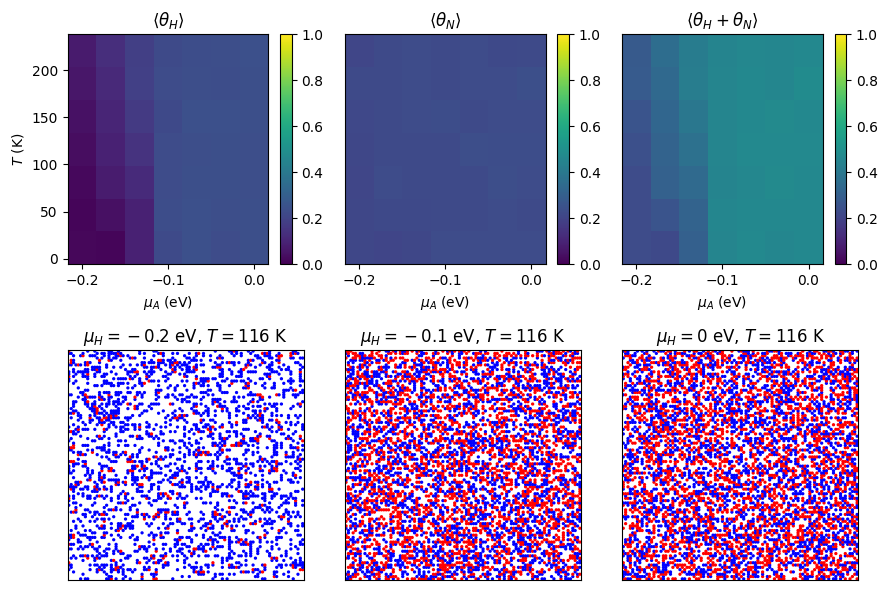

In [27]:
# Attractive Interactions between Nitrogen and Hydrogen #5
# A: Hydrogen; B: Nitrogen
# Parameters
size = 100 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 100 * 100
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': -0.05,   # epsilon_HH = -0.05 eV
            'epsilon_BB': -0.05,   # epsilon_NN = -0.05 eV
            'epsilon_AB': -0.05,   # epsilon_NH = -0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T =116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Attractive Interactions between Nitrogen and Hydrogen (Lattice Size = 100).png')
plt.show()

In [28]:
# Immiscible Nitrogen and Hydrogen

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


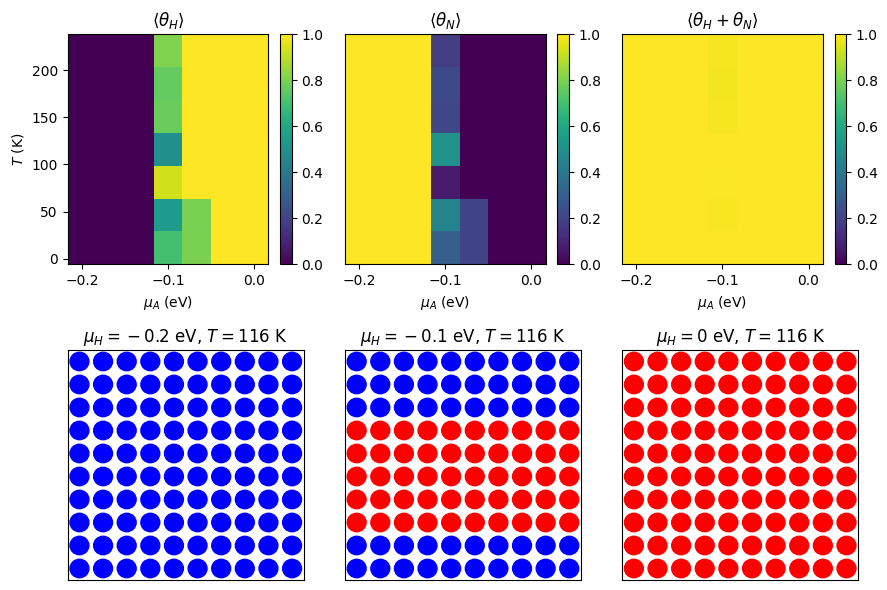

In [29]:
# Immiscible Nitrogen and Hydrogen #1
# A: Hydrogen; B: Nitrogen
# Parameters
size = 10 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 10 * 10
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': -0.05,   # epsilon_HH = -0.05 eV
            'epsilon_BB': -0.05,   # epsilon_NN = -0.05 eV
            'epsilon_AB': 0.05,   # epsilon_NH = 0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Immiscible Nitrogen and Hydrogen (Lattice Size = 10).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


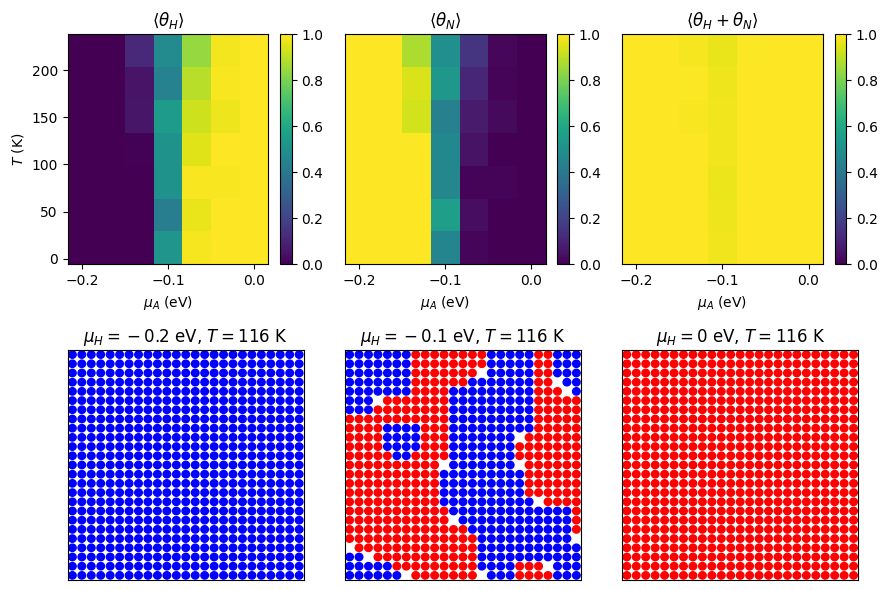

In [30]:
# Immiscible Nitrogen and Hydrogen #2
# A: Hydrogen; B: Nitrogen
# Parameters
size = 25 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 25 * 25
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': -0.05,   # epsilon_HH = -0.05 eV
            'epsilon_BB': -0.05,   # epsilon_NN = -0.05 eV
            'epsilon_AB': 0.05,   # epsilon_NH = 0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Immiscible Nitrogen and Hydrogen (Lattice Size = 25).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


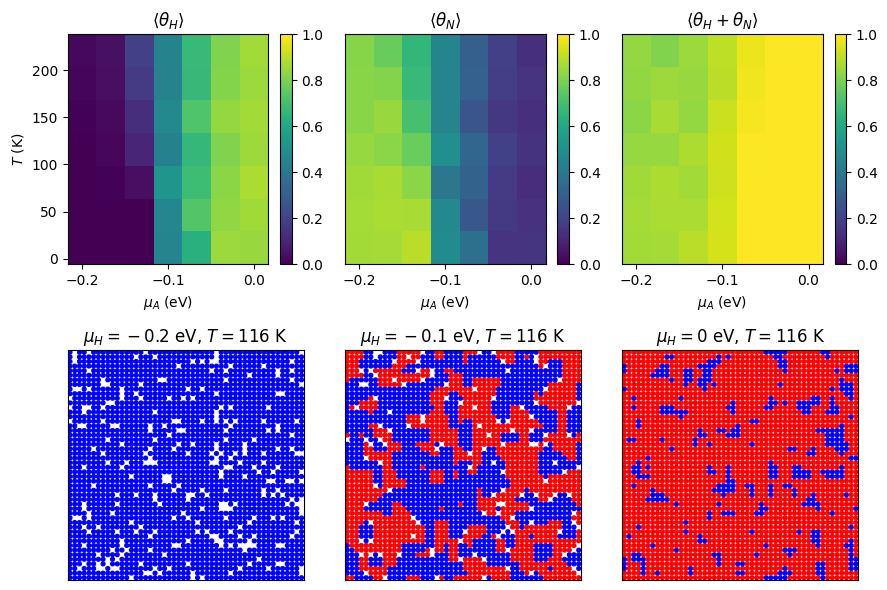

In [31]:
# Immiscible Nitrogen and Hydrogen #3
# A: Hydrogen; B: Nitrogen
# Parameters
size = 50 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 50 * 50
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': -0.05,   # epsilon_HH = -0.05 eV
            'epsilon_BB': -0.05,   # epsilon_NN = -0.05 eV
            'epsilon_AB': 0.05,   # epsilon_NH = 0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Immiscible Nitrogen and Hydrogen (Lattice Size = 50).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


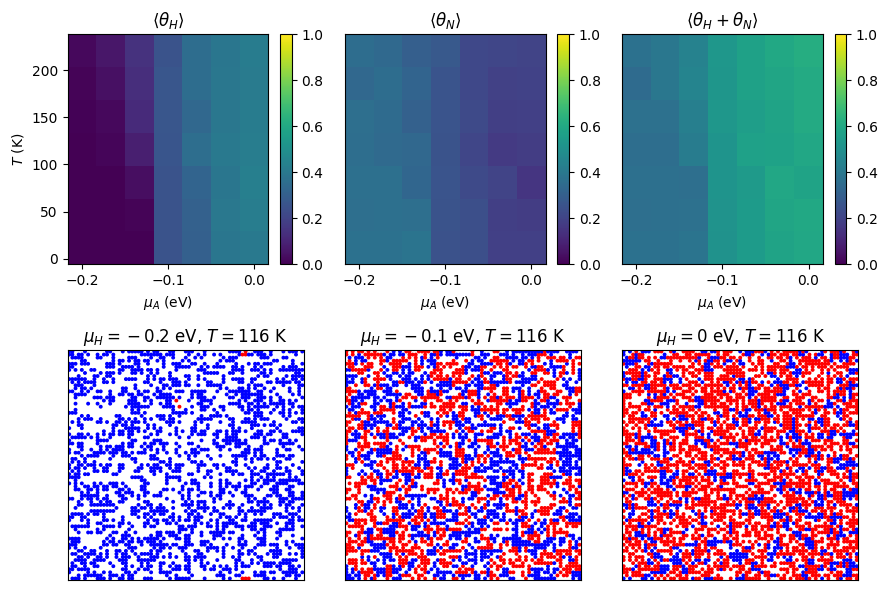

In [32]:
# Immiscible Nitrogen and Hydrogen #4
# A: Hydrogen; B: Nitrogen
# Parameters
size = 75 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 75 * 75
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': -0.05,   # epsilon_HH = -0.05 eV
            'epsilon_BB': -0.05,   # epsilon_NN = -0.05 eV
            'epsilon_AB': 0.05,   # epsilon_NH = 0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Immiscible Nitrogen and Hydrogen (Lattice Size = 75).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


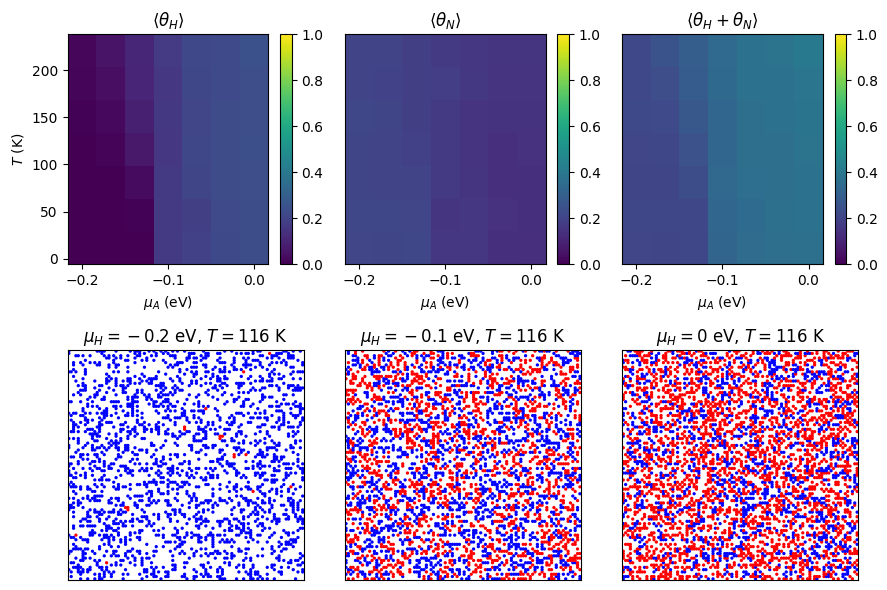

In [33]:
# Immiscible Nitrogen and Hydrogen #5
# A: Hydrogen; B: Nitrogen
# Parameters
size = 100 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 100 * 100
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': -0.05,   # epsilon_HH = -0.05 eV
            'epsilon_BB': -0.05,   # epsilon_NN = -0.05 eV
            'epsilon_AB': 0.05,   # epsilon_NH = 0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Immiscible Nitrogen and Hydrogen (Lattice Size = 100).png')
plt.show()

In [34]:
# “Like Dissolves Unlike” Scenario

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


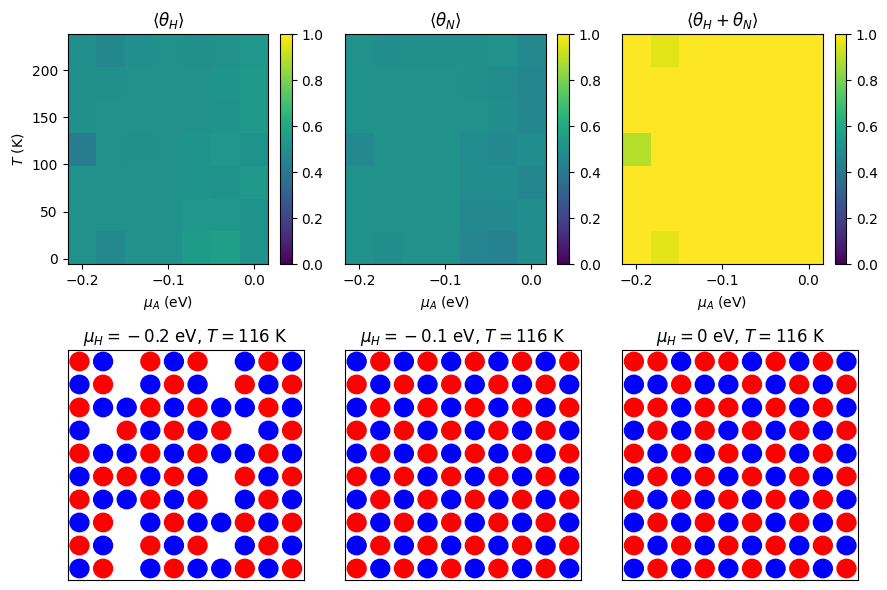

In [35]:
# “Like Dissolves Unlike” Scenario #1
# A: Hydrogen; B: Nitrogen
# Parameters
size = 10 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 10 * 10
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0.05,   # epsilon_HH = 0.05 eV
            'epsilon_BB': 0.05,   # epsilon_NN = 0.05 eV
            'epsilon_AB': -0.05,   # epsilon_NH = -0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Like Dissolves Unlike Scenario (Lattice Size = 10).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


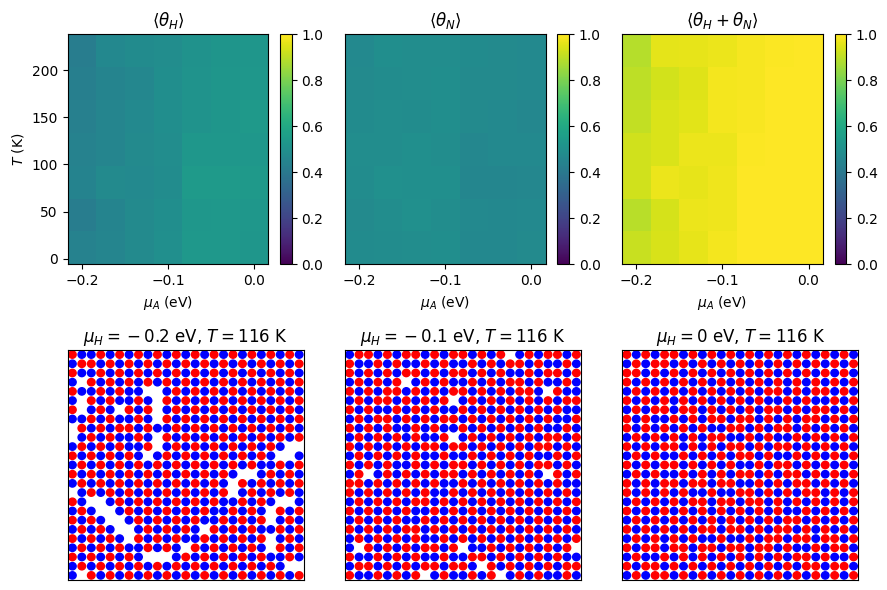

In [36]:
# “Like Dissolves Unlike” Scenario #2
# A: Hydrogen; B: Nitrogen
# Parameters
size = 25 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 25 * 25
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0.05,   # epsilon_HH = 0.05 eV
            'epsilon_BB': 0.05,   # epsilon_NN = 0.05 eV
            'epsilon_AB': -0.05,   # epsilon_NH = -0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Savet and display the plot
plt.tight_layout()
plt.savefig('Like Dissolves Unlike Scenario (Lattice Size = 25).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


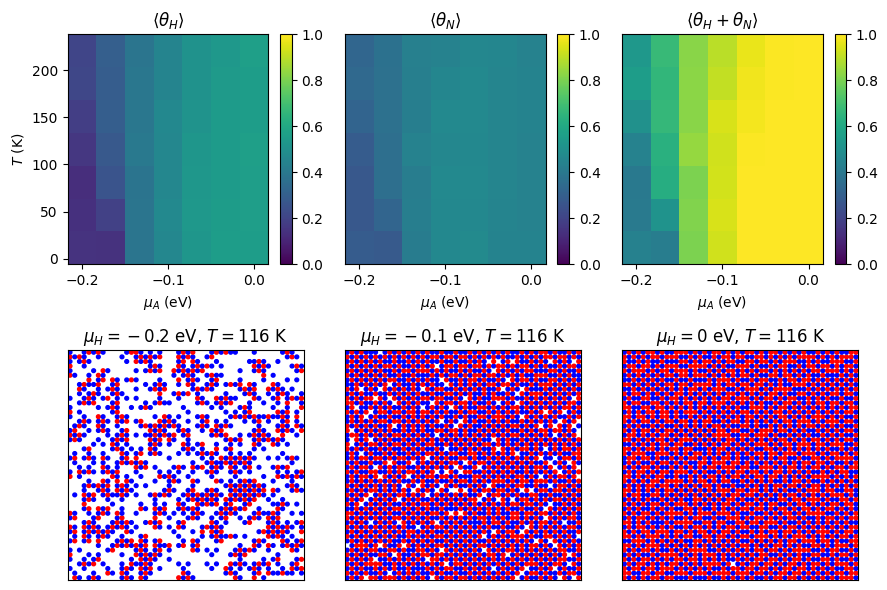

In [37]:
# “Like Dissolves Unlike” Scenario #3
# A: Hydrogen; B: Nitrogen
# Parameters
size = 50 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 50 * 50
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0.05,   # epsilon_HH = 0.05 eV
            'epsilon_BB': 0.05,   # epsilon_NN = 0.05 eV
            'epsilon_AB': -0.05,   # epsilon_NH = -0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Like Dissolves Unlike Scenario (Lattice Size = 50).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


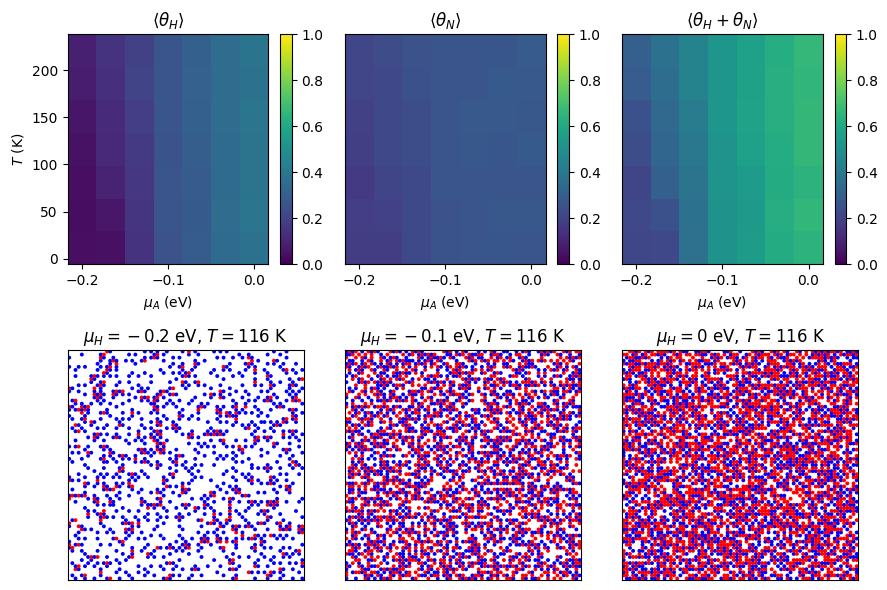

In [38]:
# “Like Dissolves Unlike” Scenario #4
# A: Hydrogen; B: Nitrogen
# Parameters
size = 75 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 75 * 75
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0.05,   # epsilon_HH = 0.05 eV
            'epsilon_BB': 0.05,   # epsilon_NN = 0.05 eV
            'epsilon_AB': -0.05,   # epsilon_NH = -0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Like Dissolves Unlike Scenario (Lattice Size = 75).png')
plt.show()

C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'blue', edgecolor = 'black')
C:\Users\16671\AppData\Local\Temp\ipykernel_26840\3947172557.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((x + 0.5, y + 0.5), 0.4, color = 'red', edgecolor = 'black')


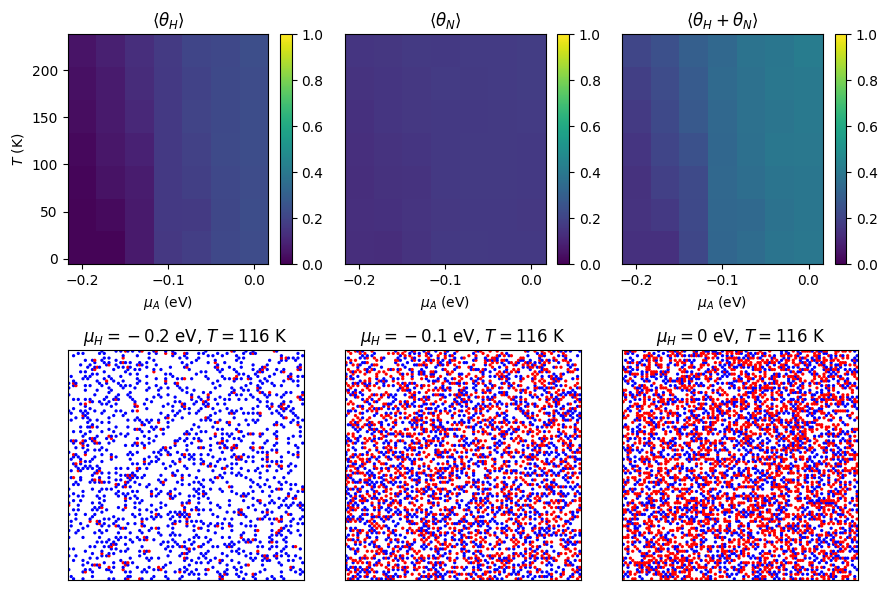

In [39]:
# “Like Dissolves Unlike” Scenario #5
# A: Hydrogen; B: Nitrogen
# Parameters
size = 100 # Investigate the effects of lattice size on the adsorption behavior and phase diagrams: Lattice size = 100 * 100
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7) # Chemical potential of Hydrogen
Ts = np.linspace(0.001, 0.019, 7) # Temperature range
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1, # epsilon_H = -0.1 eV
            'epsilon_B': -0.1, # epsilon_N = -0.1 eV
            'epsilon_AA': 0.05,   # epsilon_HH = 0.05 eV
            'epsilon_BB': 0.05,   # epsilon_NN = 0.05 eV
            'epsilon_AB': -0.05,   # epsilon_NH = -0.05 eV
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram using plt.subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6)) # Unable to use plt.subplots.mosaic, use traditional subplots here.

# Mean coverage of A
meanA = axs[0, 0].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(r'$\langle \theta_H \rangle$')
axs[0, 0].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 0].set_ylabel(r'$T$ (K)')
fig.colorbar(meanA, ax=axs[0, 0], location='right', fraction=0.1)

# Mean coverage of B
meanB = axs[0, 1].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(r'$\langle \theta_N \rangle$')
axs[0, 1].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 1].set_yticks([])
fig.colorbar(meanB, ax=axs[0, 1], location='right', fraction=0.1)

# Mean total coverage
meanTotal = axs[0, 2].pcolormesh(mus_A, Ts/(8.617*10**-5), mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[0, 2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[0, 2].set_xlabel(r'$\mu_A$ (eV)')
axs[0, 2].set_yticks([])
fig.colorbar(meanTotal, ax=axs[0, 2], location='right', fraction=0.1)

# Plot the final lattice configuration
# mu_A = -0.2 eV and T = 0.01 / k
axs[1, 0] = plot_lattice(final_lattice[0, 3], axs[1, 0], r'$\mu_H = -0.2$ eV, $T = 116$ K')

# mu_A = -0.1 eV and T = 0.01 / k
axs[1, 1] = plot_lattice(final_lattice[3, 3], axs[1, 1], r'$\mu_H = -0.1$ eV, $T = 116$ K')

# mu_A = 0 eV and T = 0.01 / k
axs[1, 2] = plot_lattice(final_lattice[6, 3], axs[1, 2], r'$\mu_H = 0$ eV, $T = 116$ K')

# Save and display the plot
plt.tight_layout()
plt.savefig('Like Dissolves Unlike Scenario (Lattice Size = 100).png')
plt.show()